# Case 2

### [Description]

<span style="font-size:18px;color:blue">
    <b>You are asked to play the role of threat analysis analysts</b> whose responsibilities include reviewing the reports from tier-1 analysts and correlate incidences to understand potential threats. 

In this case, <b>you are interested in the selected prototypical or similar netflow profiles</b>.
- The selected prototypical explanations may help you understand the decision of a network flow being determined as normal or abnormal.



We will see two examples of obtaining prototypes:
- Example 1: a network flow identified as normal 
- Example 2: a network flow identified as abnormal 
- In each case, we showcase the top five prototypes from the training data along with how similar the feature values were for these prototypes.


The network flows are identified as normal/abnormal by IDS (using on CNN models).

These network flows are collected within an enterprise network within one week. The network flow data is structured, containing the features:
- Timestamp	
- FlowDuration	
- SrcIP	
- DstIP	
- SrcPort	
- DstPort	
- Protocol	
- TypeofService	
- PacketExed	

</span>



# [Your Task]

**Make sure you have been assigned a subject ID before you start.**

<span style="font-size:18px;color:blue">
    
Your task include:
- Read the case description for each case labeled <b>"[Description]"</b> to understand your role in the case
- The cells with the label <b>"[Processing]"</b> show what the IDS algorithms are doing. **You are not asked to rate them.**
- Go through the explainations (highlighed under the title <b>"[Explaination to Rate]"</b>)
- Rate the helpfulness, correctness and the ease of understanding <b>using this <a href="https://utampa.az1.qualtrics.com/jfe/form/SV_8qe0l6fDXD8V6Ad">link</a>.</b> 
    - Each explanation can be tracked by its id (for example, EC21)
    
</span>

### [Processing]  Load UGR dataset and show sample applicants

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.algorithms.protodash import ProtodashExplainer
from aix360.datasets.ugr_dataset import UGRDataset


heloc = UGRDataset()
print(heloc.dataframe().shape)
df = heloc.dataframe()
#df.rename( columns={'Unnamed: 0':'ID'}, inplace=True )
#df.pop('ID')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
print("Size of UGR dataset:", df.shape)
print("Number of \"Normal\" connection:", np.sum(df['Label']==0))
print("Number of \"Abnormal\" connection:", np.sum(df['Label']==1))
print("Sample connections:")
df.head(10).transpose()

Using TensorFlow backend.


!!!!!!!!!!!test1
Using UGR dataset2:  /home/ec2-user/aix360/UGR-processing/AIX-UGR/aix360/datasets/../data/heloc_data/ugr_dataset.csv
(1083605, 10)
Size of UGR dataset: (1083605, 10)
Number of "Normal" connection: 633312
Number of "Abnormal" connection: 450293
Sample connections:


,0,1,2,3,4,5,6,7,8,9
Timestamp,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FlowDuration,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SrcIP,4.164107e+09,7.190350e+08,7.190364e+08,3.554046e+09,2.215383e+09,3.104125e+09,7.190356e+08,7.190350e+08,7.190347e+08,3.526242e+09
DstIP,7.190333e+08,1.244120e+09,1.423065e+09,7.190356e+08,7.190326e+08,7.190362e+08,1.053671e+09,2.403863e+09,1.244008e+09,7.190347e+08
SrcPort,4.973800e+04,8.000000e+01,3.490000e+03,5.016300e+04,3.914300e+04,4.430000e+02,4.430000e+02,4.698900e+04,5.300000e+01,3.542300e+04
DstPort,2.200000e+01,5.413100e+04,2.210000e+03,4.430000e+02,1.900000e+03,5.377900e+04,3.312400e+04,5.300000e+01,5.721400e+04,5.300000e+01
Protocol,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
TypeofService,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
PacketExed,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Label,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [2]:
df.shape

(1083605, 10)

Distribution of several features:


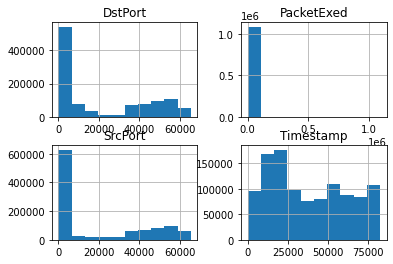

In [3]:
# Plot (example) distributions for two features
print("Distribution of several features:")
hist = df.hist(column=['PacketExed', 'Timestamp', 'SrcPort','DstPort'], bins=10)

### [Processing] Process and Normalize  dataset for training


In [4]:
# Clean data and split dataset into train/test
#print(heloc.dataframe().shape)
(Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()
#print(y_test_b)


Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

[[0.00000000e+00 0.00000000e+00 4.16410692e+09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.19034999e+08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.19036359e+08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.68000000e+04 0.00000000e+00 3.65089480e+09 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [6.12000000e+04 0.00000000e+00 3.65089480e+09 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [6.12000000e+04 0.00000000e+00 3.65089480e+09 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


<a name="c2"></a>
### [Processing]  Define and train a NN classifier
 

In [5]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=9, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model 

In [7]:
# Set random seeds for repeatability
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['0', '1']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = False

if (TRAIN_MODEL): 
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=50, verbose=1, shuffle=False)
    nn.save_weights("ugr_nnsmall.h5")     
else:    
    nn.load_weights("ugr_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                100       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
Train accuracy: 0.8696768684256354
Test accuracy: 0.8705509741512546


<a name="good"></a>
### [Processing]  Obtain similar samples as explanations for a network flow predicted as "nromal" (Example 1)


In [8]:
p_train = nn.predict_classes(xn_train) # Use trained neural network to predict train points
p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((xn_train, p_train)) # Store (normalized) instances that were predicted as Good
z_train_good = z_train[z_train[:,-1]==1, :]


zun_train = np.hstack((x_train, p_train)) # Store (unnormalized) instances that were predicted as Good 
zun_train_good = zun_train[zun_train[:,-1]==1, :]
print(z_train_good)

[[ 0.15217391 -0.5         0.19622445 ... -0.5        -0.5
   1.        ]
 [-0.32608696 -0.5         0.32883812 ... -0.5        -0.5
   1.        ]
 [ 0.2826087  -0.5        -0.45047225 ... -0.5        -0.5
   1.        ]
 ...
 [-0.2826087  -0.5         0.48903889 ... -0.5        -0.5
   1.        ]
 [-0.2826087  -0.49992275  0.15184287 ... -0.5        -0.49999542
   1.        ]
 [-0.2826087  -0.5         0.22690057 ... -0.5        -0.5
   1.        ]]


### [Description]
<span style="font-size:18px;color:blue">
One network flow has been selected for a close look. This selected netowrk flow was identified as normal.

You can find the prediction details about the selected network flow below.
    </span>


In [11]:
idx = 8

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)

print("Chosen Sample:", idx)
print("Prediction made by the model (0: normal, 1: abnormal):", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

# attach the prediction made by the model to X
X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

Xun = x_test[idx].reshape((1,) + x_test[idx].shape) 
dfx = pd.DataFrame.from_records(Xun.astype('double')) # Create dataframe with original feature values
dfx[23] = class_names[int(X[0, -1])]
dfx.columns = df.columns
dfx.transpose()


Chosen Sample: 8
Prediction made by the model (0: normal, 1: abnormal): 0
Prediction probabilities: [[ 2.3155174 -2.109797 ]]



,0
Timestamp,72000
FlowDuration,0
SrcIP,2.23256e+09
DstIP,7.19036e+08
SrcPort,57067
DstPort,10021
Protocol,1
TypeofService,0
PacketExed,0
Label,0


####  [Processing] Find similar network connections predicted as "normal" 

In [12]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_train_good, m=5) # Return weights W, Prototypes S and objective function values

#### [Processing]  Display similar network connections and the extent to which they are similar to the chosen netowrk connection as indicated by the last row in the table below labelled as "Weight".

In [13]:
dfs = pd.DataFrame.from_records(zun_train_good[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_good[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

,0,1,2,3,4
Timestamp,82800,75600,75600,82800,82800
FlowDuration,0,0,0,0,0
SrcIP,7.19034e+08,4.17259e+09,4.17156e+09,7.19034e+08,7.19034e+08
DstIP,7.19035e+08,7.19035e+08,7.19035e+08,7.19035e+08,7.19035e+08
SrcPort,64152,53,53,64153,64152
DstPort,2492,53,53,2604,2605
Protocol,1,2,2,1,1
TypeofService,0,0,0,0,0
PacketExed,0,0,0,0,0
Label,1,1,1,1,1


## [Explanation to Rate] ID: EC21

<span style="font-size:18px;color:blue">

Given the selected network flow that was identified as normal network flow, we have found 5 similar network flows (i.e., prototypical network flows) that were also identified as normal network flows. 

The following table depicts the five network flows:
- Each column is one network flow, they are labeled as 0, 1, 2, 3, 4
- The rows are the features of the network flow. 
- The values in the cells are the importance weight.
    - The more similar the feature of prototypical network flow is to the selected network flow, the closer its importance weight is to 1. 

<b>You want to pay attention to the feature similarity table, how many features of this prototype are identical to that of the chosen network connection. </b> 
- You can look at the prototypical network flows and their features surmises that the selected network flow belongs to a group of normal netowrk flows.

Do you think the table give you more confidence in deciding the chosen network connection is normal?



 <b>Rate the following explanations as a whole in the survey. The id is **EC21**</b>
 
</span>

In [15]:
z = z_train_good[S, 0:-1] # Store chosen prototypes
eps = 1e-10 # Small constant defined to eliminate divide-by-zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]):
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps)) # Compute feature similarity in [0,1]
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose() 

,0,1,2,3,4
Timestamp,0.05,0.36,0.36,0.05,0.05
FlowDuration,1.00,1.00,1.00,1.00,1.00
SrcIP,0.41,0.32,0.32,0.41,0.41
DstIP,0.00,0.00,0.00,0.00,0.00
SrcPort,0.80,0.16,0.16,0.80,0.80
DstPort,0.00,0.00,0.00,0.00,0.00
Protocol,1.00,0.13,0.13,1.00,1.00
TypeofService,1.00,1.00,1.00,1.00,1.00
PacketExed,1.00,1.00,1.00,1.00,1.00


<a name="bad"></a>
### [Description] 

<span style="font-size:18px;color:blue">

<b> Example 2. Obtaining similar samples as explanations for a connection predicted as "abnoral". </b>


- We now consider a network connection identified as abnormal. We obtained a contrastive explanation for this netowrk connection before. 

- Steps similar to example 1 are followed in this case too, where we first process the data, obtain prototypes and their importance weights, and finally showcase how similar the features are of these prototypes to the user we want to explain.
    
</span>

#### [Processing] Normalize the data and chose a particular applicant, whose profile is displayed below.


In [16]:
z_train_bad = z_train[z_train[:,-1]==0, :]
zun_train_bad = zun_train[zun_train[:,-1]==0, :]

In [17]:
idx = 272 #another user to try 2385

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Chosen Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

# move samples to a dataframe to display
Xun = x_test[idx].reshape((1,) + x_test[idx].shape)
dfx = pd.DataFrame.from_records(Xun.astype('double'))
dfx[23] = class_names[int(X[0, -1])]
dfx.columns = df.columns
dfx.transpose()

Chosen Sample: 272
Prediction made by the model: 0
Prediction probabilities: [[ 1.3223863 -1.3674397]]



,0
Timestamp,57600
FlowDuration,0
SrcIP,7.19036e+08
DstIP,2.00406e+09
SrcPort,24020
DstPort,445
Protocol,1
TypeofService,0
PacketExed,0
Label,0


#### [Processing] Find similar applicants predicted as "bad" using the protodash explainer. 

In [18]:
(W, S, setValues) = explainer.explain(X, z_train_bad, m=5) # Return weights W, Prototypes S and objective function values


# move samples to a dataframe to display
dfs = pd.DataFrame.from_records(zun_train_bad[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_bad[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Compute normalized importance weights for prototypes
dfs.transpose()

,0,1,2,3,4
Timestamp,57600,75600,0,79200,82800
FlowDuration,0,0,0,3343.9,0
SrcIP,7.19036e+08,7.19036e+08,7.19036e+08,7.19036e+08,7.19035e+08
DstIP,1.9709e+09,4.29089e+09,4.25369e+09,3.49559e+09,4.28658e+09
SrcPort,23948,65060,80,0,25
DstPort,445,445,10544,0,4236
Protocol,1,1,1,6,1
TypeofService,0,0,0,0,0
PacketExed,0,0,0,3355,0
Label,0,0,0,0,0


## [Explanation to Rate] ID: EC22

<span style="font-size:18px;color:blue">

You are provided a selected network flow which was identified as abnormal network flow. Again, 5 netowrk flows (i.e., prototypical network flows) similar to the selected network flow are shown in the table below.
- The columns of the table refer to the id of the 5 netowrk flows: 0, 1, 2, 3, 4
- The cells contain the values of similarity scores. 
- The values in the cells are the importance weight.
    - The more similar the feature of prototypical network flow is to the selected network flow, the closer its importance weight is to 1. 
- <b>You want to look at the prototypical network flows and their features surmises that the selected network flow belongs to a group of abnormal netowrk flows.</b>
- Pay attention to the feature similarity, how many features of this prototype are identical to that of the selected network flow.  



Do you think the above table give you more confidence in deciding the chosen network connection is abnormnal?



Rate the following explanations as a whole in the survey. The id is **EC22**

</span>

In [19]:
z = z_train_bad[S, 0:-1] # Store the prototypes
eps = 1e-10 # Small constant to guard against divide by zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]): # Compute feature similarity for each prototype
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps))
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()  

,0,1,2,3,4
Timestamp,1.00,0.56,0.15,0.50,0.44
FlowDuration,1.00,1.00,1.00,0.08,1.00
SrcIP,1.00,1.00,0.72,0.32,0.07
DstIP,0.96,0.08,0.08,0.19,0.08
SrcPort,1.00,0.20,0.39,0.39,0.39
DstPort,1.00,1.00,0.08,0.89,0.39
Protocol,1.00,1.00,1.00,0.08,1.00
TypeofService,1.00,1.00,1.00,1.00,1.00
PacketExed,1.00,1.00,1.00,0.08,1.00


## Thank you for completing the task. Please submit the evaluation survey. 